<a href="https://colab.research.google.com/github/ankush0939/Zinc-Defficiency-detection-and-Itensity-analysis/blob/main/VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
data_dir = '/content/drive/MyDrive/Major Project/Dataset/LabelledRice/Labelled'

In [ ]:
data_transforms ={
    "train_transforms": transforms.Compose([transforms.RandomRotation(30),
                                           transforms.RandomResizedCrop(224),
                                           transforms.RandomHorizontalFlip(),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406],
                                                                [0.229, 0.224, 0.225])]),
   "valid_transforms": transforms.Compose([transforms.Resize(225),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406],
                                                                [0.229, 0.224, 0.225])]), 
    "test_transforms": transforms.Compose([transforms.Resize(225),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406],
                                                                [0.229, 0.224, 0.225])])
}


1.   *Load the datasets with ImageFolder*
2.   *Obtain training indices that will be used for validation and test*

In [ ]:
train_data = 0.8
valid_data = 0.1
test_data = 0.1

train_data = datasets.ImageFolder(data_dir, transform=data_transforms["train_transforms"])
valid_data = datasets.ImageFolder(data_dir, transform=data_transforms["valid_transforms"])
test_data = datasets.ImageFolder(data_dir, transform=data_transforms["test_transforms"])

num_train = len(train_data)
indices = list(range(num_train))

train_count = int(0.8*num_train)
valid_count = int(0.1*num_train)
test_count = num_train - train_count - valid_count
train_idx = indices[:train_count]
valid_idx = indices[train_count:train_count+valid_count]
test_idx = indices[train_count+valid_count:]

print(len(train_idx), len(valid_idx), len(test_idx))
print("Training", train_count, np.sum(len(train_idx)/num_train))
print("Validation", valid_count, np.sum(len(valid_idx)/num_train))
print("Test", test_count, np.sum(len(test_idx)/num_train))


2888 361 362
Training 2888 0.7997784547216837
Validation 361 0.09997230684021047
Test 362 0.10024923843810579


In [ ]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

In [ ]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size = 16, shuffle = True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size = 8, sampler = valid_sampler)
testloader = torch.utils.data.DataLoader(test_data, batch_size = 8, sampler = test_sampler)

In [ ]:
print("Classes: ")
class_names = train_data.classes
print(train_data.classes)

Classes: 
['BrownSpot', 'Healthy']


In [ ]:
classes=train_data.classes

In [ ]:
len(class_names)

2

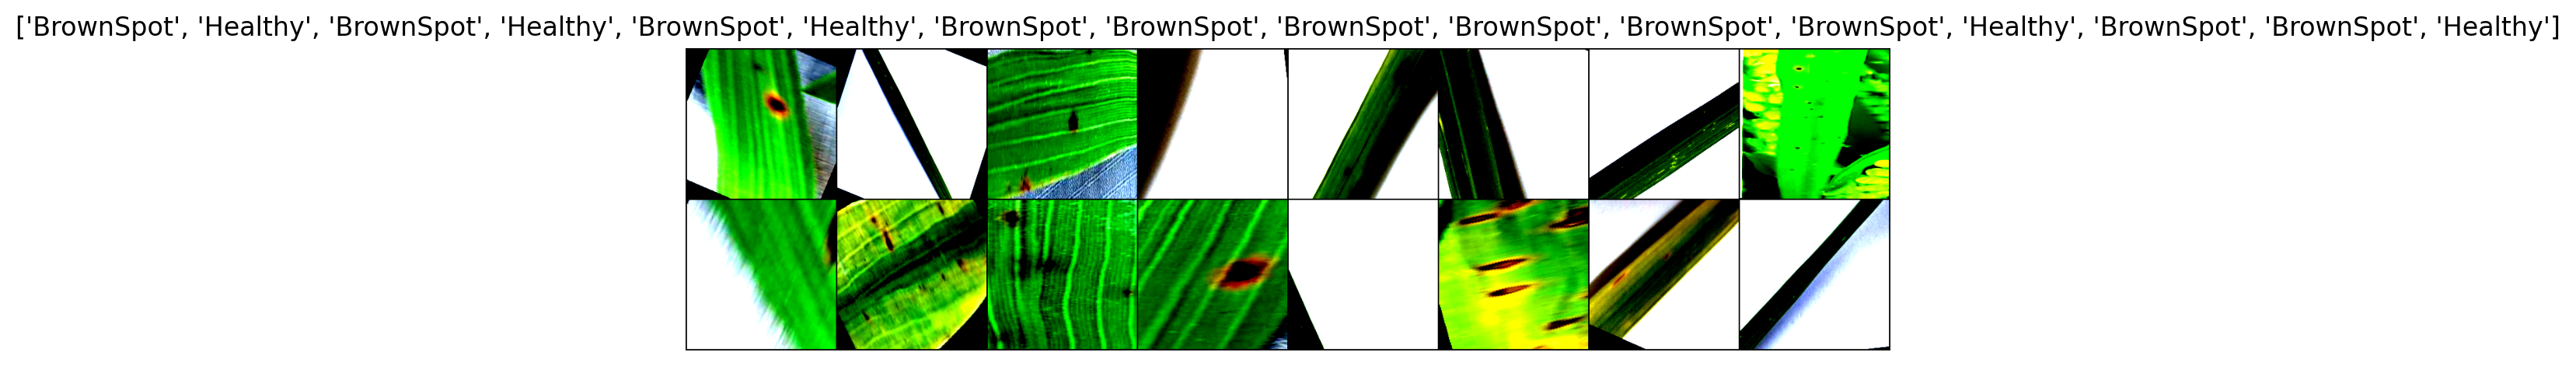

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])


inputs, classes = next(iter(trainloader))   # Get a batch of training data
show_databatch(inputs, classes)


In [ ]:
model_transfer = models.vgg16(pretrained=True)
print(model_transfer)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 185MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
print(model_transfer.classifier[6].out_features)

1000


1.   **Freeze training for all layers**

In [ ]:

for param in model_transfer.features.parameters():
    param.require_grad = False

num_features = model_transfer.classifier[6].in_features
features = list(model_transfer.classifier.children())[:-1]       # Remove last layer
features.extend([nn.Linear(num_features, len(class_names))])     # Add our layer with 2 outputs
model_transfer.classifier = nn.Sequential(*features)             # Replace the model classifier
print(model_transfer)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

Using CUDA


In [ ]:
from torch.optim import lr_scheduler

In [ ]:
# if use_gpu:
#     model_transfer.cuda() #.cuda() will move everything to the GPU side
    
# criterion = nn.CrossEntropyLoss()
# #optimizer_ft = torch.optim.Adam(model_transfer.parameters(), lr = 0.001)
# optimizer_ft = optim.SGD(model_transfer.parameters(), lr=0.0001, momentum=0.9)
# #exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
import time
import copy

In [ ]:
# Train the model
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    '''returns trained model'''
    # Initialize tracker for minimum validation loss
    valid_loss_min = np.inf
  
    for epoch in range(1, n_epochs+1):
        since = time.time()
        # Initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
    
        # Model training
        model.train()
        for batch_idx, (data,target) in enumerate(trainloader):
            # Move to GPU
            if use_cuda:
                data,target = data.cuda(), target.cuda()
      
            # Clear the gradient of all optimized variables
            optimizer.zero_grad()
            # Forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # Calculate the batch loss
            loss = criterion(output, target)
            # Backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # Perform a single optimization step (parameter update)
            optimizer.step()
            # Record the average training loss
            train_loss = train_loss + ((1/ (batch_idx + 1 ))*(loss.data-train_loss))
      
        # Model validation
        model.eval()
        for batch_idx, (data,target) in enumerate(validloader):
            # Move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # Update the average validation loss
            # Forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # Calculate the batch loss
            loss = criterion(output, target)
            # Update the average validation loss
            valid_loss = valid_loss + ((1/ (batch_idx +1)) * (loss.data - valid_loss))
      
        # print training/validation stats
        print('Epoch: {} \tTraining Loss: {:.5f} \tValidation Loss: {:.5f}'.format(
            epoch,
            train_loss,
            valid_loss))
        
        elapsed_time = time.time() - since
        print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))   
    
        
        # Save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.5f} --> {:.5f}). Saving model ...'.format(
                  valid_loss_min,
                  valid_loss))
            torch.save(model.state_dict(), 'model_transfer.pt')
            valid_loss_min = valid_loss
  
    # Return trained model
    return model

In [ ]:
loaders_transfer = {'train': trainloader,
                    'valid': validloader,
                    'test': testloader}

In [ ]:
model_transfer = train(15, loaders_transfer, model_transfer, optimizer_ft, criterion, use_gpu, 'model_transfer.pt')

Epoch: 1 	Training Loss: 0.28573 	Validation Loss: 0.18404
Training completed in 14m 54s
Validation loss decreased (inf --> 0.18404). Saving model ...
Epoch: 2 	Training Loss: 0.16681 	Validation Loss: 0.27902
Training completed in 6m 54s
Epoch: 3 	Training Loss: 0.14565 	Validation Loss: 0.16114
Training completed in 6m 51s
Validation loss decreased (0.18404 --> 0.16114). Saving model ...
Epoch: 4 	Training Loss: 0.13575 	Validation Loss: 0.07788
Training completed in 6m 52s
Validation loss decreased (0.16114 --> 0.07788). Saving model ...
Epoch: 5 	Training Loss: 0.12063 	Validation Loss: 0.06593
Training completed in 6m 52s
Validation loss decreased (0.07788 --> 0.06593). Saving model ...
Epoch: 6 	Training Loss: 0.11758 	Validation Loss: 0.10176
Training completed in 6m 52s
Epoch: 7 	Training Loss: 0.10015 	Validation Loss: 0.05174
Training completed in 6m 52s
Validation loss decreased (0.06593 --> 0.05174). Saving model ...
Epoch: 8 	Training Loss: 0.10627 	Validation Loss: 0.0528

In [ ]:
def test(loaders, model, criterion, use_cuda):

    test_loss = 0.
    correct = 0.
    total = 0.

    model_transfer.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        
        output = model(data)
        
        loss = criterion(output, target)
         
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        
        pred = output.data.max(1, keepdim=True)[1]
         
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

  
test(loaders_transfer, model_transfer, criterion, use_gpu)

Test Loss: 0.062779


Test Accuracy: 98% (356/362)


In [ ]:
from google.colab import files

In [ ]:
files.download('model_transfer.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>